# Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/sorix/blob/develop/docs/examples/nn/1-regression.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/Mitchell-Mirano/sorix/blob/develop/docs/examples/nn/1-regression.ipynb)
[![Open in Docs](https://img.shields.io/badge/Open%20in-Docs-blue?logo=readthedocs)](http://127.0.0.1:8000/examples/nn/1-regression)

In [1]:
# Uncomment the next line and run this cell to install sorix
#!pip install 'sorix @ git+https://github.com/Mitchell-Mirano/sorix.git@develop'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import sorix
from sorix.nn import ReLU,Linear
from sorix.optim import RMSprop
from sorix import tensor,Tensor
from sorix.nn import Module
from sorix.nn import  MSELoss
from sorix.preprocessing import MinMaxScaler
from sorix.model_selection import train_test_split
from sorix.metrics import r2_score

In [3]:
device  = 'cuda' if sorix.cuda.is_available() else 'cpu'
device

✅ GPU basic operation passed
✅ GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 14.0.1


'cuda'

## Datos

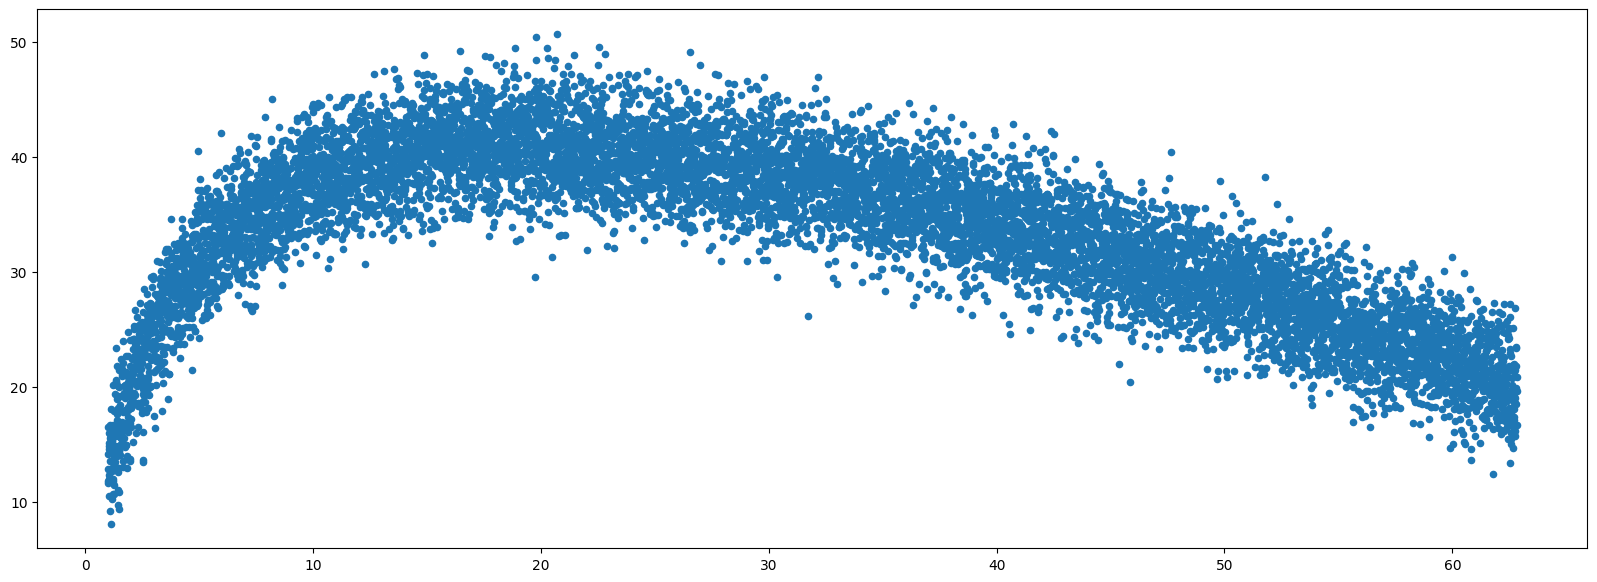

In [4]:
# Datos
points = 10000
x1 = np.linspace(1, 20*np.pi, points)
x2 = np.linspace(1, 20*np.pi, points)

# Definimos la salida
y = 20*np.log(x1+1) + -1*x2 + 3*np.random.randn(points)


data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data.head()

plt.figure(figsize=(20,7))
plt.scatter(data['x2'], data['y'], s=20)
plt.show()


## Preprocessing

In [5]:
independent_variables = ['x1', 'x2']
dependent_variable = ['y']

In [6]:
# Train test split and normalization
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

X_train = df_train[independent_variables]
Y_train = df_train[dependent_variable]

X_test = df_test[independent_variables]
Y_test = df_test[dependent_variable]

X_train

,x1,x2
6252,39.661141,39.661141
4684,29.964936,29.964936
1731,11.704164,11.704164
4742,30.323597,30.323597
4521,28.956976,28.956976
...,...,...
1638,11.129070,11.129070
5891,37.428788,37.428788
7427,46.927110,46.927110
608,4.759753,4.759753


In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[0.62526253, 0.62526253],
       [0.46844684, 0.46844684],
       [0.17311731, 0.17311731],
       ...,
       [0.74277428, 0.74277428],
       [0.06080608, 0.06080608],
       [0.69076908, 0.69076908]], shape=(8000, 2))

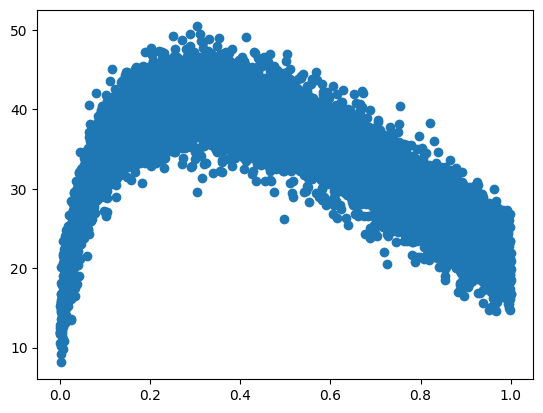

In [8]:
plt.Figure(figsize=(20,7))
plt.scatter(X_train[:,0], Y_train)
plt.show()

In [9]:
X_train = tensor(X_train,dtype=sorix.float32,device=device)
Y_train = tensor(Y_train,dtype=sorix.float32,device=device)

X_test = tensor(X_test, dtype=sorix.float32,device=device)
Y_test = tensor(Y_test, dtype=sorix.float32,device=device)

print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}. device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")

X_train shape: (8000, 2), device: cuda
Y_train shape: (8000, 1). device: cuda
X_test shape: (2000, 2), device: cuda
Y_test shape: (2000, 1), device: cuda


In [10]:
class Network(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)
        self.relu = ReLU()

    def forward(self, x: tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

net = Network()
net.to(device)
net

Network(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [11]:
criterion = MSELoss()
optimizer = RMSprop(net.parameters(), lr=1e-2)

In [12]:
Y_pred = net(X_train)
Y_pred

Tensor(
[[0.6408244 ]
 [0.48010576]
 [0.17742594]
 ...
 [0.7612608 ]
 [0.06231946]
 [0.7079614 ]], shape=(8000, 1), dtype=float32, device=cuda, requires_grad=True)

In [13]:
# %%
# Bucle de entrenamiento mejorado
for epoch in range(1000 + 1):
    Y_pred = net(X_train)
    loss = criterion(Y_train,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        r2_train = r2_score(Y_pred, Y_train)
        with sorix.no_grad():
            Y_pred = net(X_test)
            r2_test = r2_score(Y_test, Y_pred)
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.item():.4f} | R2_Train: {100*r2_train:5.2f} % | R2_Test: {100*r2_test:5.2f} %")
        if r2_test > 0.95:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

[cuda] Epoch     0 | Loss: 1141.8185 | R2_Train: -1303275.88 % | R2_Test: -1792.54 %
[cuda] Epoch    10 | Loss: 329.6601 | R2_Train: -140.65 % | R2_Test: -516.52 %
[cuda] Epoch    20 | Loss: 271.0833 | R2_Train: -139.03 % | R2_Test: -404.53 %
[cuda] Epoch    30 | Loss: 190.1652 | R2_Train: -187.08 % | R2_Test: -245.83 %
[cuda] Epoch    40 | Loss: 102.7367 | R2_Train: -385.80 % | R2_Test: -84.67 %
[cuda] Epoch    50 | Loss: 53.5220 | R2_Train: -15508.93 % | R2_Test:  0.71 %
[cuda] Epoch    60 | Loss: 42.9413 | R2_Train: -1278.98 % | R2_Test: 20.17 %
[cuda] Epoch    70 | Loss: 39.9022 | R2_Train: -484.37 % | R2_Test: 25.04 %
[cuda] Epoch    80 | Loss: 37.8725 | R2_Train: -347.34 % | R2_Test: 29.00 %


[cuda] Epoch    90 | Loss: 36.3946 | R2_Train: -297.28 % | R2_Test: 31.92 %
[cuda] Epoch   100 | Loss: 34.9680 | R2_Train: -260.80 % | R2_Test: 34.49 %
[cuda] Epoch   110 | Loss: 33.3349 | R2_Train: -223.41 % | R2_Test: 37.40 %
[cuda] Epoch   120 | Loss: 31.6152 | R2_Train: -186.86 % | R2_Test: 40.57 %
[cuda] Epoch   130 | Loss: 29.9707 | R2_Train: -152.39 % | R2_Test: 43.61 %
[cuda] Epoch   140 | Loss: 28.4311 | R2_Train: -121.05 % | R2_Test: 46.63 %
[cuda] Epoch   150 | Loss: 28.8154 | R2_Train: -113.13 % | R2_Test: 46.20 %


[cuda] Epoch   160 | Loss: 25.1763 | R2_Train: -60.16 % | R2_Test: 51.15 %
[cuda] Epoch   170 | Loss: 22.7396 | R2_Train: -28.50 % | R2_Test: 56.77 %
[cuda] Epoch   180 | Loss: 21.8213 | R2_Train: -12.04 % | R2_Test: 58.89 %
[cuda] Epoch   190 | Loss: 20.9165 | R2_Train:  2.41 % | R2_Test: 60.27 %
[cuda] Epoch   200 | Loss: 19.7222 | R2_Train: 16.17 % | R2_Test: 62.22 %
[cuda] Epoch   210 | Loss: 18.7227 | R2_Train: 26.44 % | R2_Test: 64.04 %
[cuda] Epoch   220 | Loss: 17.9780 | R2_Train: 33.84 % | R2_Test: 65.37 %
[cuda] Epoch   230 | Loss: 17.4024 | R2_Train: 39.23 % | R2_Test: 66.37 %
[cuda] Epoch   240 | Loss: 16.9032 | R2_Train: 43.42 % | R2_Test: 67.22 %
[cuda] Epoch   250 | Loss: 16.4684 | R2_Train: 46.79 % | R2_Test: 67.89 %


[cuda] Epoch   260 | Loss: 16.0986 | R2_Train: 49.47 % | R2_Test: 68.51 %
[cuda] Epoch   270 | Loss: 17.3539 | R2_Train: 45.86 % | R2_Test: 66.26 %
[cuda] Epoch   280 | Loss: 15.8195 | R2_Train: 52.40 % | R2_Test: 68.19 %
[cuda] Epoch   290 | Loss: 15.0048 | R2_Train: 55.55 % | R2_Test: 70.52 %
[cuda] Epoch   300 | Loss: 15.1672 | R2_Train: 55.24 % | R2_Test: 70.51 %
[cuda] Epoch   310 | Loss: 15.2987 | R2_Train: 55.12 % | R2_Test: 70.03 %
[cuda] Epoch   320 | Loss: 15.0687 | R2_Train: 56.19 % | R2_Test: 70.30 %


[cuda] Epoch   330 | Loss: 14.8329 | R2_Train: 57.20 % | R2_Test: 70.79 %
[cuda] Epoch   340 | Loss: 14.7355 | R2_Train: 57.70 % | R2_Test: 70.98 %
[cuda] Epoch   350 | Loss: 14.6529 | R2_Train: 58.15 % | R2_Test: 71.09 %
[cuda] Epoch   360 | Loss: 14.5520 | R2_Train: 58.67 % | R2_Test: 71.23 %
[cuda] Epoch   370 | Loss: 14.4359 | R2_Train: 59.24 % | R2_Test: 71.44 %
[cuda] Epoch   380 | Loss: 14.3416 | R2_Train: 59.71 % | R2_Test: 71.62 %
[cuda] Epoch   390 | Loss: 14.2729 | R2_Train: 60.10 % | R2_Test: 71.74 %
[cuda] Epoch   400 | Loss: 14.1933 | R2_Train: 60.49 % | R2_Test: 71.89 %
[cuda] Epoch   410 | Loss: 14.1225 | R2_Train: 60.82 % | R2_Test: 72.02 %
[cuda] Epoch   420 | Loss: 14.0531 | R2_Train: 61.17 % | R2_Test: 72.15 %


[cuda] Epoch   430 | Loss: 13.9927 | R2_Train: 61.46 % | R2_Test: 72.28 %
[cuda] Epoch   440 | Loss: 13.9356 | R2_Train: 61.74 % | R2_Test: 72.38 %
[cuda] Epoch   450 | Loss: 13.8793 | R2_Train: 62.02 % | R2_Test: 72.49 %
[cuda] Epoch   460 | Loss: 13.8225 | R2_Train: 62.28 % | R2_Test: 72.61 %
[cuda] Epoch   470 | Loss: 13.7700 | R2_Train: 62.52 % | R2_Test: 72.71 %
[cuda] Epoch   480 | Loss: 13.7200 | R2_Train: 62.72 % | R2_Test: 72.82 %
[cuda] Epoch   490 | Loss: 13.6717 | R2_Train: 62.93 % | R2_Test: 72.91 %


[cuda] Epoch   500 | Loss: 13.6249 | R2_Train: 63.15 % | R2_Test: 73.01 %
[cuda] Epoch   510 | Loss: 13.5826 | R2_Train: 63.35 % | R2_Test: 73.08 %
[cuda] Epoch   520 | Loss: 13.5389 | R2_Train: 63.56 % | R2_Test: 73.17 %
[cuda] Epoch   530 | Loss: 13.4963 | R2_Train: 63.73 % | R2_Test: 73.27 %
[cuda] Epoch   540 | Loss: 13.4579 | R2_Train: 63.90 % | R2_Test: 73.34 %
[cuda] Epoch   550 | Loss: 13.4133 | R2_Train: 64.07 % | R2_Test: 73.43 %
[cuda] Epoch   560 | Loss: 13.3778 | R2_Train: 64.23 % | R2_Test: 73.50 %


[cuda] Epoch   570 | Loss: 13.3334 | R2_Train: 64.42 % | R2_Test: 73.58 %
[cuda] Epoch   580 | Loss: 13.2857 | R2_Train: 64.61 % | R2_Test: 73.68 %
[cuda] Epoch   590 | Loss: 13.2534 | R2_Train: 64.76 % | R2_Test: 73.74 %
[cuda] Epoch   600 | Loss: 13.2085 | R2_Train: 64.95 % | R2_Test: 73.83 %
[cuda] Epoch   610 | Loss: 13.1676 | R2_Train: 65.12 % | R2_Test: 73.91 %
[cuda] Epoch   620 | Loss: 13.1329 | R2_Train: 65.27 % | R2_Test: 73.98 %
[cuda] Epoch   630 | Loss: 13.0781 | R2_Train: 65.48 % | R2_Test: 74.09 %


[cuda] Epoch   640 | Loss: 13.0403 | R2_Train: 65.67 % | R2_Test: 74.13 %
[cuda] Epoch   650 | Loss: 13.0233 | R2_Train: 65.78 % | R2_Test: 74.17 %
[cuda] Epoch   660 | Loss: 12.9944 | R2_Train: 65.91 % | R2_Test: 74.23 %
[cuda] Epoch   670 | Loss: 12.9638 | R2_Train: 66.02 % | R2_Test: 74.30 %
[cuda] Epoch   680 | Loss: 12.9390 | R2_Train: 66.12 % | R2_Test: 74.36 %
[cuda] Epoch   690 | Loss: 12.9092 | R2_Train: 66.22 % | R2_Test: 74.42 %
[cuda] Epoch   700 | Loss: 12.8832 | R2_Train: 66.33 % | R2_Test: 74.48 %
[cuda] Epoch   710 | Loss: 12.8578 | R2_Train: 66.43 % | R2_Test: 74.54 %
[cuda] Epoch   720 | Loss: 12.8132 | R2_Train: 66.58 % | R2_Test: 74.63 %
[cuda] Epoch   730 | Loss: 12.8086 | R2_Train: 66.60 % | R2_Test: 74.67 %


[cuda] Epoch   740 | Loss: 12.7978 | R2_Train: 66.62 % | R2_Test: 74.69 %
[cuda] Epoch   750 | Loss: 12.7742 | R2_Train: 66.69 % | R2_Test: 74.73 %
[cuda] Epoch   760 | Loss: 12.7546 | R2_Train: 66.77 % | R2_Test: 74.79 %
[cuda] Epoch   770 | Loss: 12.7383 | R2_Train: 66.81 % | R2_Test: 74.82 %
[cuda] Epoch   780 | Loss: 12.7219 | R2_Train: 66.88 % | R2_Test: 74.86 %
[cuda] Epoch   790 | Loss: 12.7088 | R2_Train: 66.94 % | R2_Test: 74.91 %
[cuda] Epoch   800 | Loss: 12.6856 | R2_Train: 66.99 % | R2_Test: 74.94 %


[cuda] Epoch   810 | Loss: 12.6735 | R2_Train: 67.06 % | R2_Test: 74.98 %
[cuda] Epoch   820 | Loss: 12.6564 | R2_Train: 67.10 % | R2_Test: 75.02 %
[cuda] Epoch   830 | Loss: 12.6400 | R2_Train: 67.18 % | R2_Test: 75.06 %
[cuda] Epoch   840 | Loss: 12.6219 | R2_Train: 67.23 % | R2_Test: 75.10 %
[cuda] Epoch   850 | Loss: 12.6055 | R2_Train: 67.30 % | R2_Test: 75.13 %
[cuda] Epoch   860 | Loss: 12.5897 | R2_Train: 67.36 % | R2_Test: 75.17 %
[cuda] Epoch   870 | Loss: 12.5728 | R2_Train: 67.43 % | R2_Test: 75.20 %
[cuda] Epoch   880 | Loss: 12.4525 | R2_Train: 67.87 % | R2_Test: 75.46 %
[cuda] Epoch   890 | Loss: 12.5298 | R2_Train: 67.63 % | R2_Test: 75.33 %
[cuda] Epoch   900 | Loss: 12.5203 | R2_Train: 67.67 % | R2_Test: 75.30 %


[cuda] Epoch   910 | Loss: 12.4763 | R2_Train: 67.82 % | R2_Test: 75.39 %
[cuda] Epoch   920 | Loss: 12.4061 | R2_Train: 68.11 % | R2_Test: 75.62 %
[cuda] Epoch   930 | Loss: 12.4792 | R2_Train: 67.91 % | R2_Test: 75.40 %
[cuda] Epoch   940 | Loss: 12.4060 | R2_Train: 68.13 % | R2_Test: 75.51 %
[cuda] Epoch   950 | Loss: 12.3634 | R2_Train: 68.27 % | R2_Test: 75.62 %
[cuda] Epoch   960 | Loss: 12.3660 | R2_Train: 68.27 % | R2_Test: 75.63 %
[cuda] Epoch   970 | Loss: 12.3645 | R2_Train: 68.28 % | R2_Test: 75.63 %


[cuda] Epoch   980 | Loss: 12.3432 | R2_Train: 68.34 % | R2_Test: 75.67 %
[cuda] Epoch   990 | Loss: 12.3258 | R2_Train: 68.37 % | R2_Test: 75.71 %
[cuda] Epoch  1000 | Loss: 12.3132 | R2_Train: 68.41 % | R2_Test: 75.74 %


Text(0.5, 1.0, 'Polinomic Regression on Test Data(Accuracy:75.74%)')

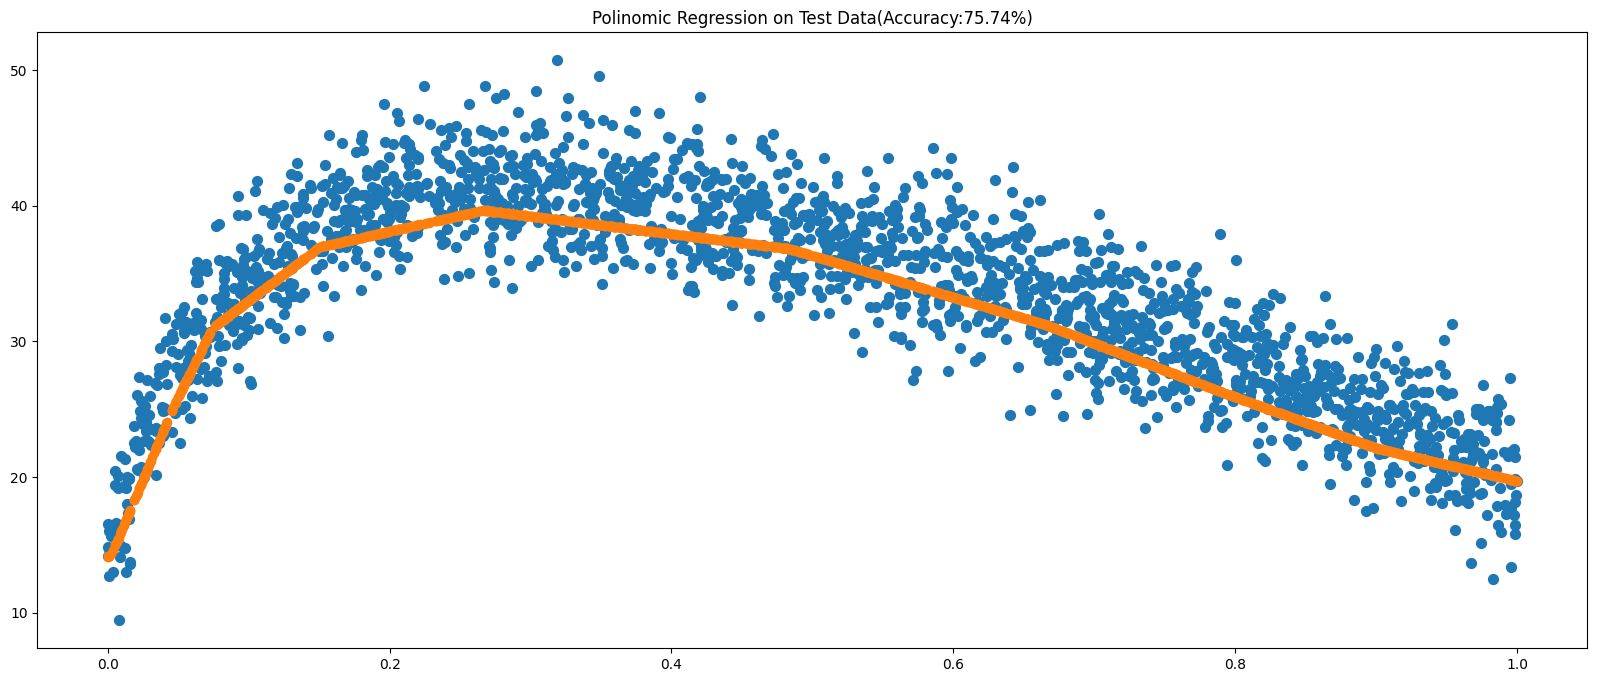

In [14]:
# %%
# Visualización final

with sorix.no_grad():
    y_pred = net(X_test)

r2 = r2_score(Y_test, y_pred)

plt.figure(figsize=(20,8))
plt.scatter(X_test[:,0],Y_test,s=50)
plt.scatter(X_test[:,0],y_pred)
plt.title(f'Polinomic Regression on Test Data(Accuracy:{r2*100:.2f}%)')

## Save and Load Model

In [15]:
sorix.save(net.state_dict(),"regression_weights.sor")

## CPU

In [16]:
net2 = Network()
net2.load_state_dict(sorix.load("regression_weights.sor"))

if X_test.device == 'cpu':
    out = net2(X_test)
if X_test.device == 'cuda':
    out = net2(X_test.to('cpu'))

out

Tensor(
[[23.533669]
 [28.878414]
 [32.002144]
 ...
 [35.125786]
 [31.904114]
 [28.78688 ]], shape=(2000, 1), dtype=float32, device=cpu, requires_grad=True)

## GPU

In [17]:
net2 = Network()
net2.load_state_dict(sorix.load("regression_weights.sor"))
net2.to('cuda')

if X_test.device == 'cpu':
    with sorix.no_grad():
        out = net2(X_test.to('cuda'))
if X_test.device == 'cuda':
    with sorix.no_grad():
        out = net2(X_test)

out

Tensor(
[[23.533669]
 [28.878416]
 [32.002144]
 ...
 [35.125782]
 [31.904114]
 [28.78688 ]], shape=(2000, 1), dtype=float32, device=cuda, requires_grad=False)